In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_images, get_depths
from utils.calib_utils import detect_keypoints, undistort_intrinsics, to_homogeneous, to_cartesian, undistort_images, transform2local, plane2plane_transformation, to_norm_image_coord, project2image, compose_fund_mat, optimize_pose_lm, pointcloudify_depths, optimize_translation_lm, average_transforms
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines, draw_chessboard_corners, normalize_image

np.set_printoptions(suppress=True)


WARNING - 2021-04-14 17:00:39,145 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-04-14 17:00:39,147 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-04-14 17:00:39,148 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
WARNING - 2021-04-14 17:00:39,149 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
T

### Load data

In [3]:
img_ext = '.png'
depth_ext = '.npy'
# Crop timestamps for each sequence to exclude moving objects
end = 20
period = 1

# List for final transformations for each sequence
T_out = []

In [4]:
# List of sequences to read data from
data_roots = iter(["/home/konstantin/datasets/bandeja-sequence/2021-04-12-20-37-19"])

In [5]:
# Select next data root
data_root = next(data_roots)

In [6]:
# Data paths

s10_images_path = data_root + "/smartphone_video_frames"
azure_images_path = data_root + "/_azure_ir_image_raw"
azure_depths_path = data_root + "/_azure_depth_image_raw"

In [7]:
# Deterime matching pairs between s10 and azure either by matching or providing the list of timestamps manually
s10_timestamps, azure_timestamps = get_matching_pairs(s10_images_path, azure_images_path)

In [8]:
# Select timestamp pairs
s10_timestamps = s10_timestamps[:end:period]
azure_timestamps = azure_timestamps[:end:period]

In [9]:
s10_images = get_images(s10_images_path, period=period, file_name_list=[fn + img_ext for fn in s10_timestamps])

In [10]:
azure_images = get_images(azure_images_path, period=period, file_name_list=[fn + img_ext for fn in azure_timestamps])
azure_depths = get_depths(azure_depths_path, period=period, file_name_list=[fn + depth_ext for fn in azure_timestamps])

In [11]:
# Load intrinsics cailbration results which should include intrinsics, distortion coefficients and undistorted intrinsics
s10_intrinsics_calib = np.load('calib_output/s10_standard_intrinsics.npy', allow_pickle=True).item()

s10_intrinsics = s10_intrinsics_calib['intrinsics']
s10_dist_coeff = s10_intrinsics_calib['dist_coeff']
s10_undist_intrinsics = s10_intrinsics_calib['undist_intrinsics']

In [12]:
# Stock calibration for azure
azure_intrinsics = np.array([[503.9581604003906, 0.0, 325.4591064453125],
                             [0.0, 504.0079345703125, 340.33404541015625],
                             [0.0, 0.0, 1.0]])

azure_dist_coeff = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

azure_undist_intrinsics = undistort_intrinsics(next(iter(azure_images.values())).shape[::-1], azure_intrinsics, azure_dist_coeff)

In [13]:
# Undistort all data before the work
s10_images = undistort_images(s10_images, s10_intrinsics, s10_dist_coeff, s10_undist_intrinsics, cv.INTER_LINEAR)
azure_images = undistort_images(azure_images, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_LINEAR)

In [14]:
azure_depths = undistort_images(azure_depths, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_NEAREST)


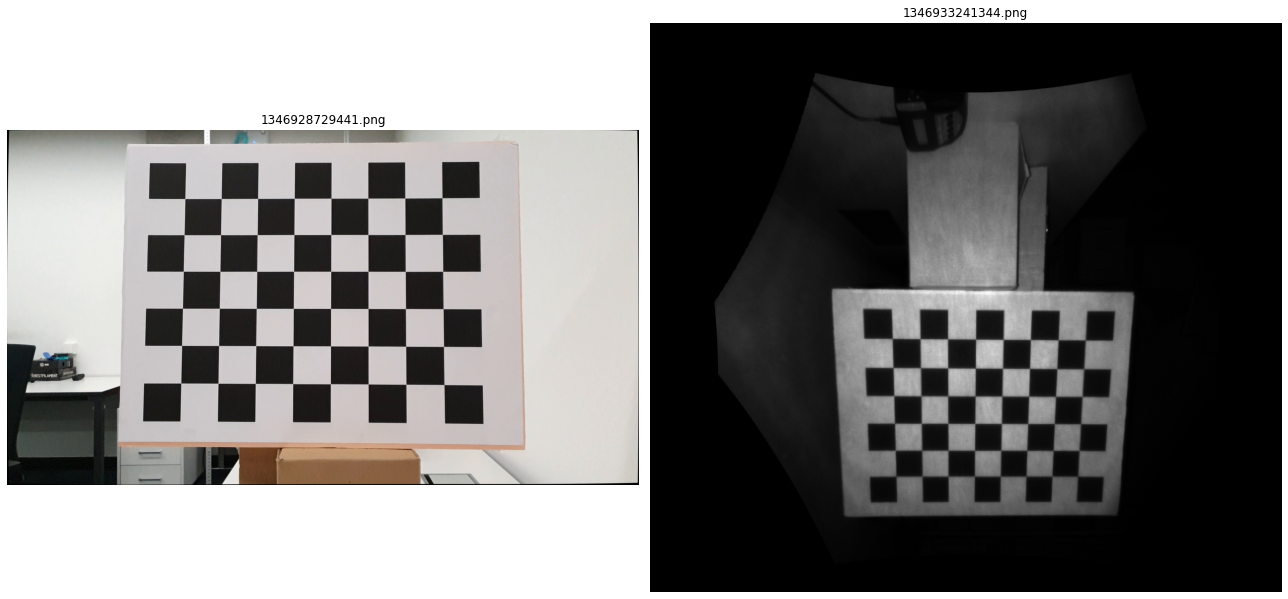

In [15]:
idx = 0

check_s10_key, check_azure_key = s10_timestamps[idx], azure_timestamps[idx]

plot_figures({check_s10_key + img_ext: s10_images[check_s10_key + img_ext], 
              check_azure_key + img_ext: azure_images[check_azure_key + img_ext]}, 1, 2)

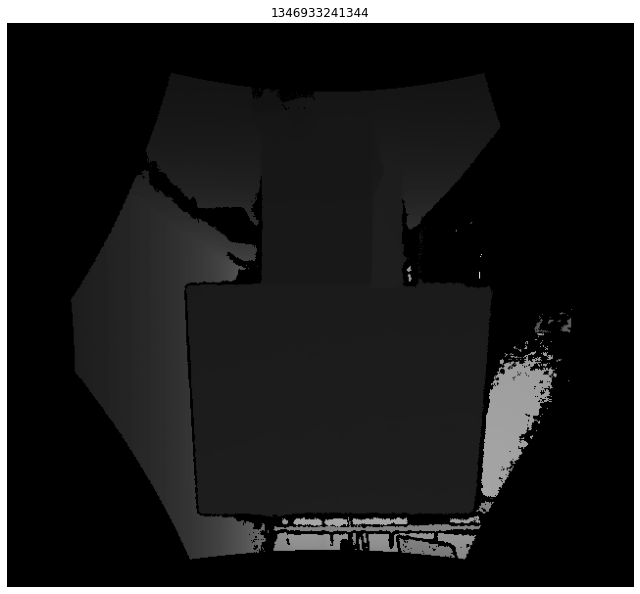

In [16]:
check_azure_depth = azure_depths[check_azure_key + depth_ext]

plot_figures({check_azure_key: check_azure_depth}, size=(9, 9))

### Detect keypoints

In [17]:
pattern_size = (8, 6)
edge_length = 0.05

In [18]:
# Detect keypoint
s10_detections = detect_keypoints(s10_images, pattern_size, edge_length)
azure_detections = detect_keypoints(azure_images, pattern_size, edge_length, invert=True)

In [19]:
# Leave only those pairs that have detections on both images
s10_det_mask = np.array([t + img_ext in s10_detections for t in s10_timestamps])
azure_det_mask = np.array([t + img_ext in azure_detections for t in azure_timestamps])

det_mask = s10_det_mask & azure_det_mask

d_s10_timestamps, d_azure_timestamps = s10_timestamps[det_mask], azure_timestamps[det_mask]

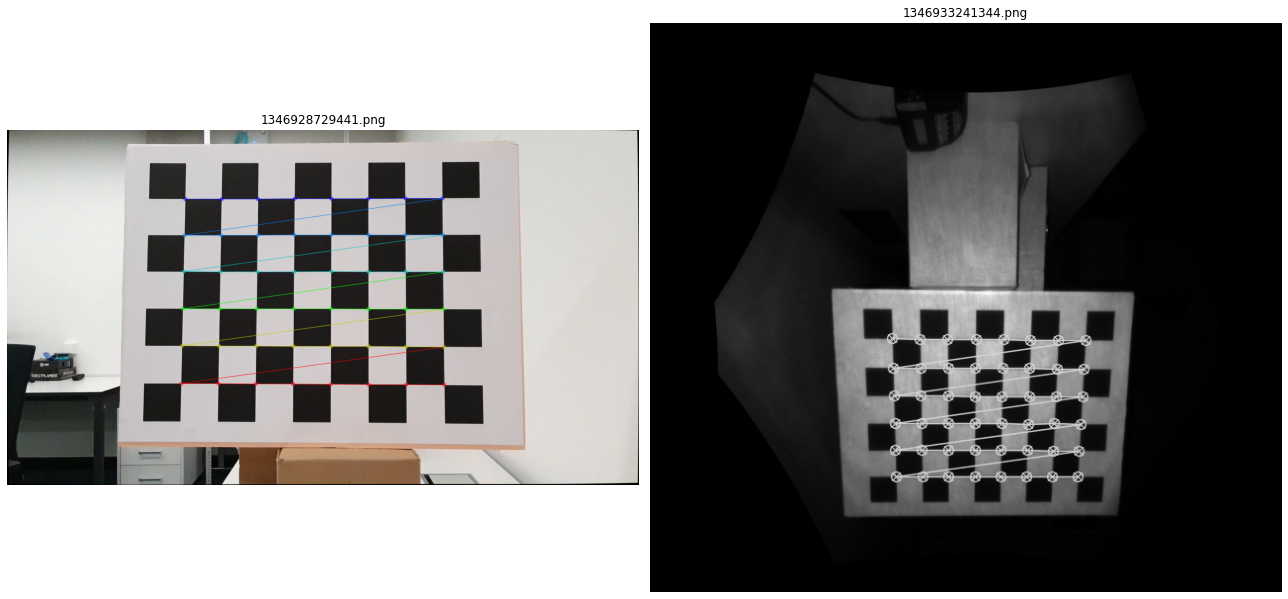

In [21]:
# Detections on azure may be innacurate. When selecting final pair make sure their detections are accurate

idx = 0

check_s10_key, check_azure_key = d_s10_timestamps[idx] + img_ext, d_azure_timestamps[idx] + img_ext


plot_figures({check_s10_key: draw_chessboard_corners(s10_images[check_s10_key], 
                                                     s10_detections[check_s10_key][1], 
                                                     pattern_size),
              check_azure_key: draw_chessboard_corners(azure_images[check_azure_key], 
                                                       azure_detections[check_azure_key][1], 
                                                       pattern_size)}, 1, 2)

### s10-to-chessboard transformation

In [22]:
# Solve PnP for find transformation between s10 keypoints and points on the board

s10_chess = {}

for ts in d_s10_timestamps:
    scene_points, kp = s10_detections[ts + img_ext]
    success, r, t = cv.solvePnP(scene_points, kp, s10_undist_intrinsics, None, flags=cv.SOLVEPNP_IPPE)
    
    if success:
        dS = np.zeros((4, 4))
        dS[:3, :3] = cv.Rodrigues(r)[0]
        dS[:3, 3] = np.reshape(t, -1)
        dS[3, 3] = 1
        
        s10_local_scene_points = to_cartesian((dS @ to_homogeneous(scene_points).transpose()).transpose())
        
        s10_chess[ts] = s10_local_scene_points


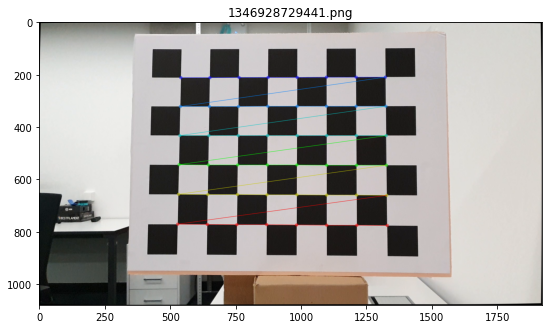

In [23]:
# Visualize transformed scene points with the estimated by PnP transformation to make sure the solution make sense
idx = 0

check_key = d_s10_timestamps[idx] + img_ext

plot_projected_keypoints(s10_images[check_key], s10_chess[check_key.split('.')[0]], s10_undist_intrinsics, check_key, pattern_size)

### azure-to-chessboard transformation

In [24]:
# Take keypoints from azure and use depth to create a point cloud out of them

azure_chess = {}

for t in d_azure_timestamps:
    kp = np.squeeze(azure_detections[t + img_ext][1], 1)
    depth = azure_depths[t + depth_ext]
    
    norm_kp = to_norm_image_coord(kp, azure_undist_intrinsics)
    
    azure_local_kp = transform2local(kp, norm_kp, depth)
    
    azure_chess[t] = azure_local_kp

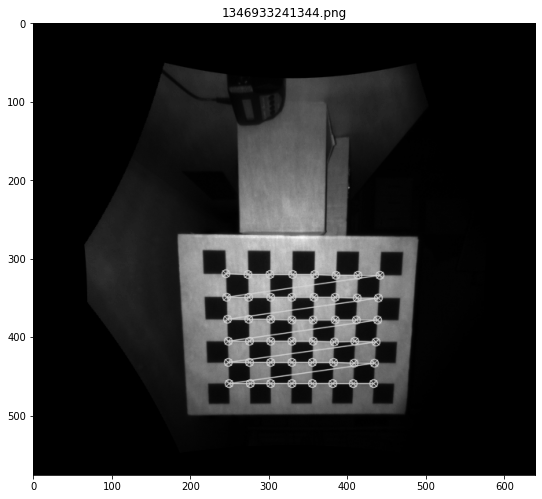

In [25]:
# Agian perform the check to make sure that obtained points are reasonable
idx = 0

check_key = d_azure_timestamps[idx] + img_ext

plot_projected_keypoints(azure_images[check_key], azure_chess[check_key.split('.')[0]], azure_undist_intrinsics, check_key, pattern_size)

In [26]:
# Visualize two chessboards next to each other and get the avg. error between corresponding points

idx = 0

check_azure_chess, check_s10_chess = azure_chess[d_azure_timestamps[idx]], s10_chess[d_s10_timestamps[idx]]

open3d.visualization.draw_geometries([to_open3d(check_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [27]:
np.linalg.norm(check_s10_chess - check_azure_chess, axis=-1).mean()

0.295209778572952

### azure-s10-extrinsics guess

In [28]:
# Estimate the point-to-point transformation between two pointclouds

extrinsics = {}

for s10_t, azure_t in zip(d_s10_timestamps, d_azure_timestamps):
    s10_chessi = s10_chess[s10_t]
    azure_chessi = azure_chess[azure_t]
    
    extrinsics[s10_t + ' ' + azure_t] = plane2plane_transformation(azure_chessi, s10_chessi)


In [29]:
# Pick only one solution (T_init) that corresponds to a pair with the best inital estimate. 
# IMPORTANT: Make sure the transformation is geometrically feasible

t_norm_p2p = []
T_p2p = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):
    azure_chessi, s10_chessi = azure_chess[azure_t], s10_chess[s10_t]
    Ti = extrinsics[s10_t + ' ' + azure_t]
    
    t_azure_chessi = to_cartesian((Ti @ to_homogeneous(azure_chessi).transpose()).transpose())
    
    t_normi = np.linalg.norm(t_azure_chessi - s10_chessi, axis=-1).mean()
    
    t_norm_p2p.append(t_normi)
    T_p2p.append(Ti)

t_norm_p2p = np.array(t_norm_p2p)
T_p2p = np.array(T_p2p)

In [30]:
t_norm_idx = np.argsort(t_norm_p2p)

T_init = T_p2p[t_norm_idx[0]]

print(T_init)

[[-0.99849781  0.00020336  0.02457967 -0.01009878]
 [ 0.00701251 -0.96965395  0.1249747  -0.04481122]
 [ 0.024147    0.12513539  0.99150296 -0.02697875]
 [ 0.          0.          0.          1.        ]]


In [31]:
# Check the selected transformation
idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess, check_s10_chess = azure_chess[check_azure_key], s10_chess[check_s10_key]

check_T = T_init

In [32]:
# 1) avg. error between points
check_t_azure_chess = to_cartesian((check_T @ to_homogeneous(check_azure_chess).transpose()).transpose())

np.linalg.norm(check_t_azure_chess - check_s10_chess, axis=-1).mean()

0.022092478678495838

In [33]:
# 2) by examining the solution visually
open3d.visualization.draw_geometries([to_open3d(check_t_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


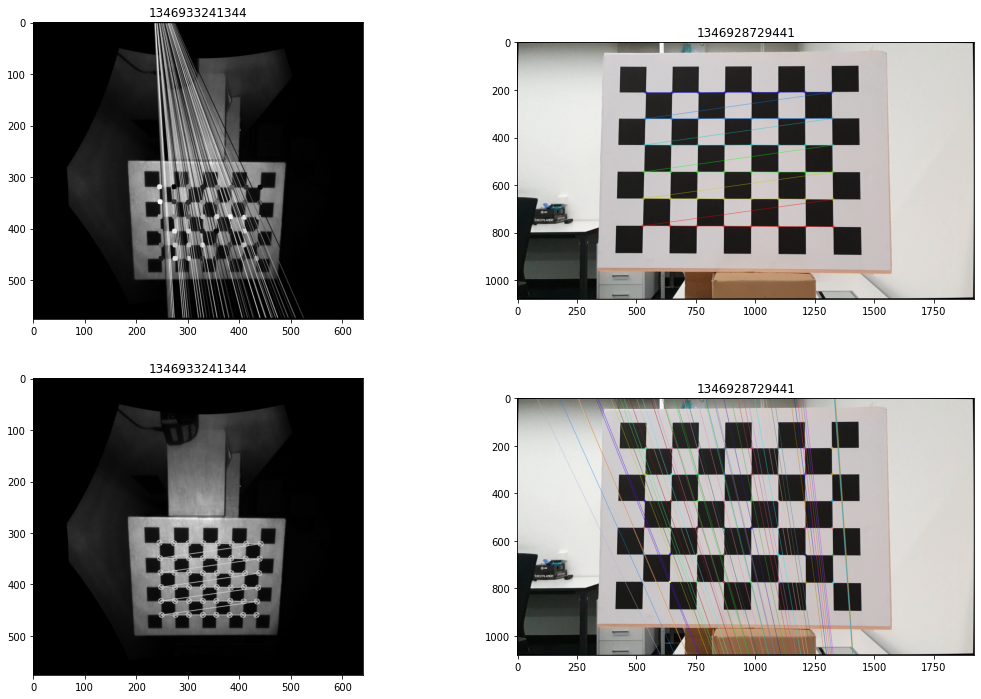

In [34]:
# 3) by plotting epipolar lines 

check_F = compose_fund_mat(check_T, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + img_ext], s10_images[check_s10_key + img_ext], 
                    azure_detections[check_azure_key + img_ext][1], s10_detections[check_s10_key + img_ext][1],
                    check_azure_key, check_s10_key, check_F, pattern_size)

In [35]:
# The initial solution as can be seen from epipolar lines is highly inaccurate thus we need to further 
# minimize avg. epipolar distance

T_opt = []

t_norm = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):    
    s10_kp, azure_kp = np.squeeze(s10_detections[s10_t + img_ext][1]), np.squeeze(azure_detections[azure_t + img_ext][1])
    local_kp1i = azure_chess[azure_t]
    
    print("Index:", i)
    
    # Do separate optimization for the initial guess to find pairs where the convergence is possible with relatively low error
    
    print("F optimization")
    
    T_opti = optimize_pose_lm(T_init, azure_kp, s10_kp, azure_undist_intrinsics, s10_undist_intrinsics)    
    
    if T_opti is not None:
        # Do optimization to find translation magnitude
        
        print("t optimization")
        
        T_opti, t_normi = optimize_translation_lm(T_opti, local_kp1i, s10_kp, s10_undist_intrinsics)
        
        T_opt.append(T_opti)
        
        t_norm.append(t_normi)
    
    print()

t_norm = np.array(t_norm)
T_opt = np.array(T_opt)
best_t_norm_idx = np.argsort(t_norm)

Index: 0
F optimization
Avg. epipolar distance: 0.16763194051365163
Number of iters: 14
t optimization
Avg. l2-norm: 0.6417919104206948
Number of iters: 27
Translation scale: -2.226126888051793

Index: 1
F optimization
Avg. epipolar distance: 0.16661235493390217
Number of iters: 14
t optimization
Avg. l2-norm: 0.6835501022569082
Number of iters: 27
Translation scale: -2.22476908610861

Index: 2
F optimization
Avg. epipolar distance: 0.1652974639353341
Number of iters: 14
t optimization
Avg. l2-norm: 0.6776447305496195
Number of iters: 27
Translation scale: -2.221949470804188

Index: 3
F optimization
Avg. epipolar distance: 0.16465316439039826
Number of iters: 14
t optimization
Avg. l2-norm: 0.648929208936237
Number of iters: 29
Translation scale: -2.221167947487675

Index: 4
F optimization
Avg. epipolar distance: 0.16186744880123527
Number of iters: 13
t optimization
Avg. l2-norm: 0.6286354359022911
Number of iters: 29
Translation scale: -2.218665075030986

Index: 5
F optimization
Avg.

In [36]:
print(np.arange(len(best_t_norm_idx)))
print(best_t_norm_idx)
print(t_norm[best_t_norm_idx])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[18  4 12  0  8 14 11  3 19 16  7 13  6 17 15  2  1 10  5  9]
[0.61522836 0.62863544 0.63839878 0.64179191 0.64307884 0.64327367
 0.64512964 0.64892921 0.65786298 0.65960507 0.66225119 0.6683584
 0.67284637 0.67430654 0.67555004 0.67764473 0.6835501  0.6913977
 0.69850108 0.71209345]


In [37]:
# Select T to examine
# np.arange(len(best_t_norm_idx))
select_idx = 0
selected_idx = best_t_norm_idx[select_idx]

print("Selected best idx:", selected_idx)
print("Selected avg. norm:", t_norm[selected_idx])

sel_T_opt = T_opt[selected_idx]

Selected best idx: 18
Selected avg. norm: 0.6152283568900269


In [38]:
sel_T_opt

array([[-0.99997931, -0.0056163 ,  0.00313742,  0.00269367],
       [ 0.00530618, -0.9958031 , -0.09136757,  0.10471359],
       [ 0.0036374 , -0.09134903,  0.99581229,  0.05516527],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Visualize transformed keypoints, depth

In [39]:
# Either select one transformation or average over several of them

# T_final = average_transforms(sel_T_opt)
T_final = sel_T_opt

In [40]:
T_final

array([[-0.99997931, -0.0056163 ,  0.00313742,  0.00269367],
       [ 0.00530618, -0.9958031 , -0.09136757,  0.10471359],
       [ 0.0036374 , -0.09134903,  0.99581229,  0.05516527],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

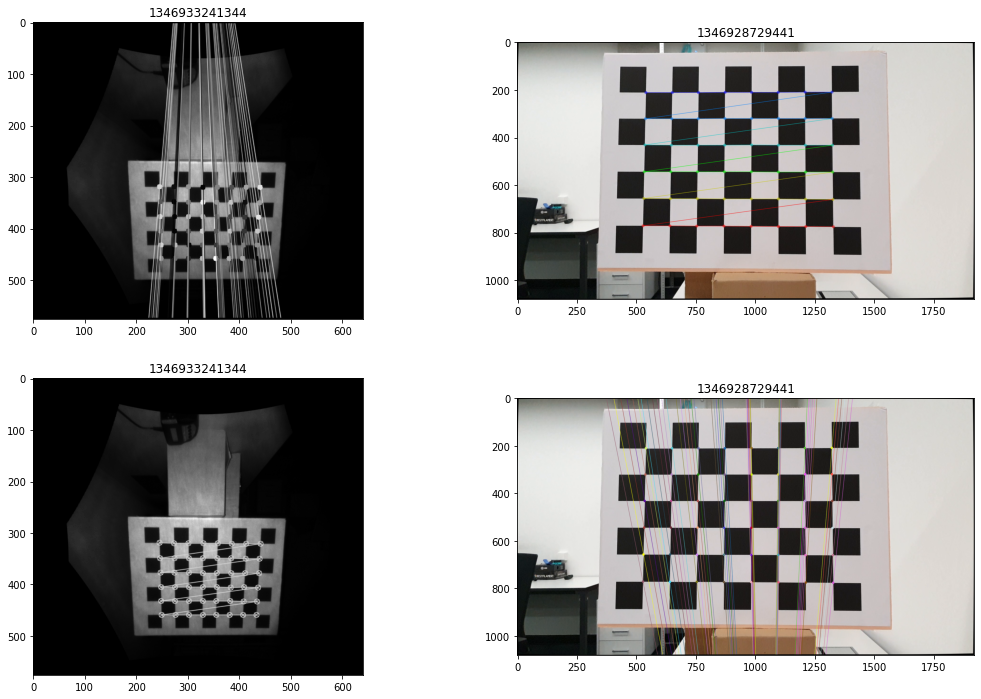

In [41]:
# Examine the solution after the optimization. Lines should be close to their corresponding points 
idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_F = compose_fund_mat(T_final, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + '.png'], s10_images[check_s10_key + '.png'],
                    azure_detections[check_azure_key + '.png'][1], s10_detections[check_s10_key + '.png'][1], 
                    check_azure_key, check_s10_key, check_F, pattern_size)


In [42]:
# Transform all depth measurements to a point cloud
azure_pcd_depths = pointcloudify_depths(azure_depths, azure_undist_intrinsics)

Re-proj. error:  0.6512655646656925


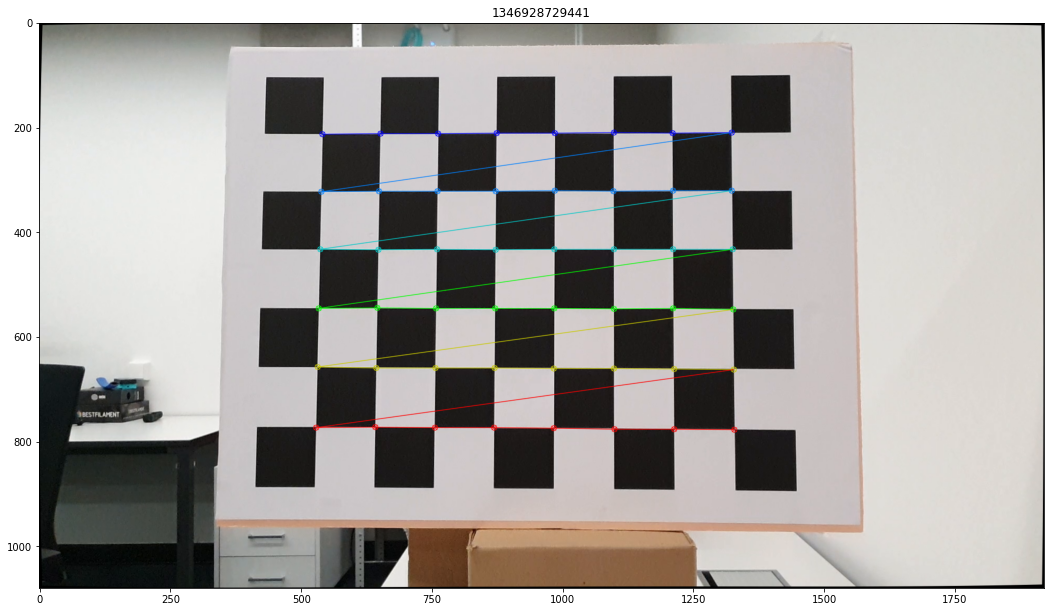

In [43]:
# Keypoints should be well aligned with their respective locations on multiple images

idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess = to_cartesian((T_final @ to_homogeneous(azure_chess[check_azure_key]).transpose()).transpose())
check_s10_kp = np.squeeze(s10_detections[check_s10_key + img_ext][1], 1)

check_re_proj_error = np.linalg.norm(project2image(check_azure_chess, s10_undist_intrinsics) - check_s10_kp, axis=-1).mean()

print("Re-proj. error: ", check_re_proj_error)

plot_projected_keypoints(s10_images[check_s10_key + img_ext], check_azure_chess, 
                         s10_undist_intrinsics, check_s10_key, pattern_size, fig_size=(18, 18))


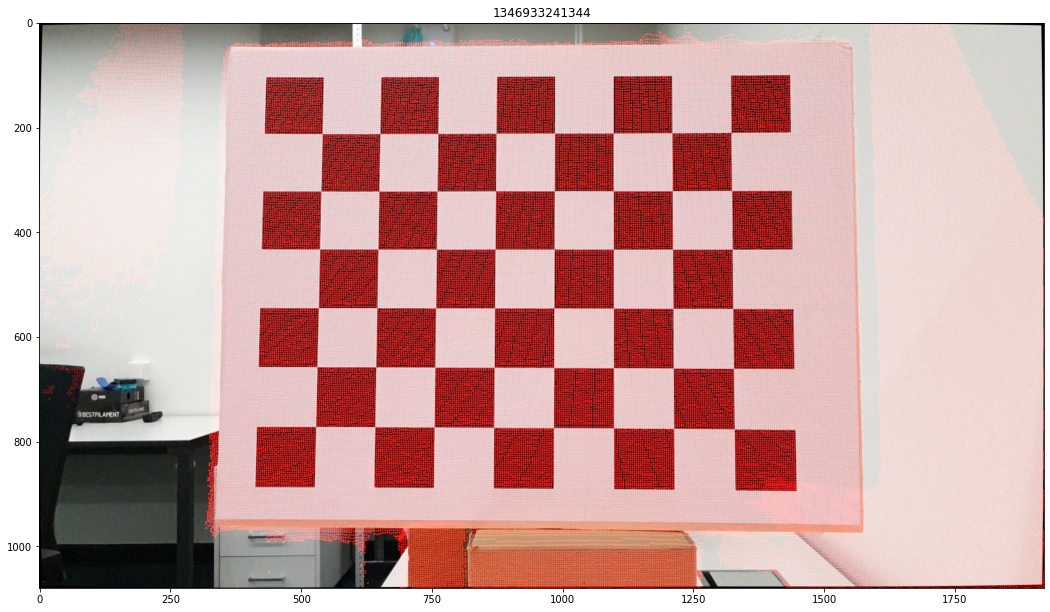

In [44]:
# Transform pointcloudified depth from azure to s10 system of coordinates and visualize it as a final check

check_azure_pcd = azure_pcd_depths[check_azure_key + depth_ext]
check_azure_pcd = to_cartesian((T_final @ to_homogeneous(check_azure_pcd).transpose()).transpose())

plot_projected_pcd(s10_images[check_s10_key + img_ext], check_azure_pcd, s10_undist_intrinsics, check_azure_key)

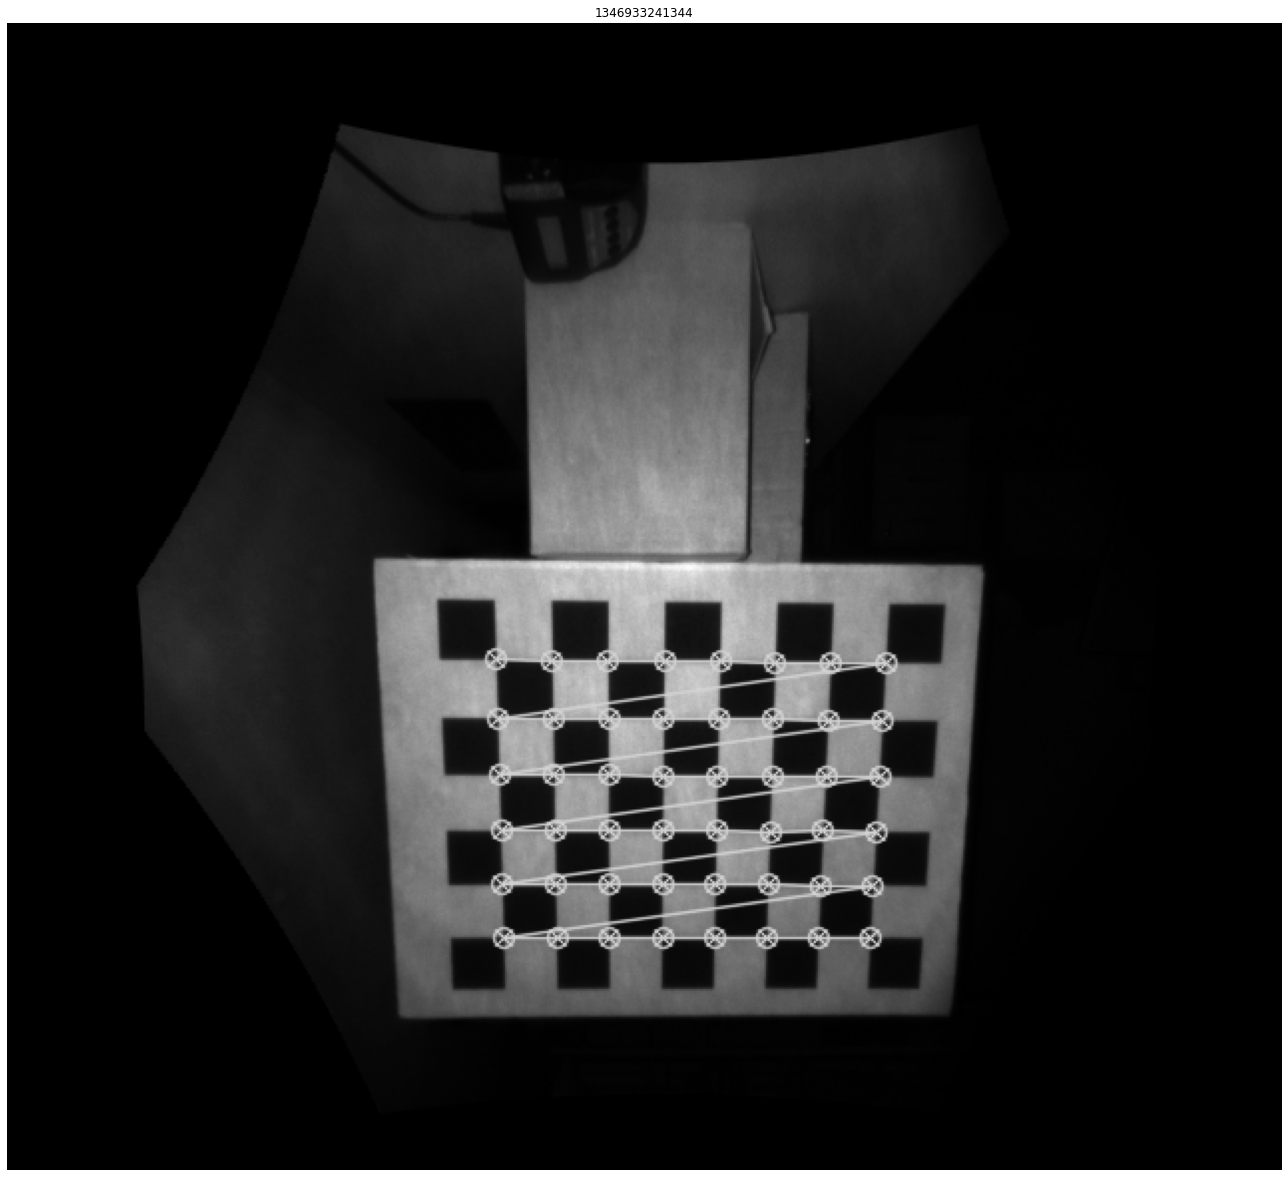

In [45]:
plot_figures({check_azure_key: draw_chessboard_corners(azure_images[check_azure_key + img_ext], 
                                                       azure_detections[check_azure_key + img_ext][1], 
                                                       pattern_size)})

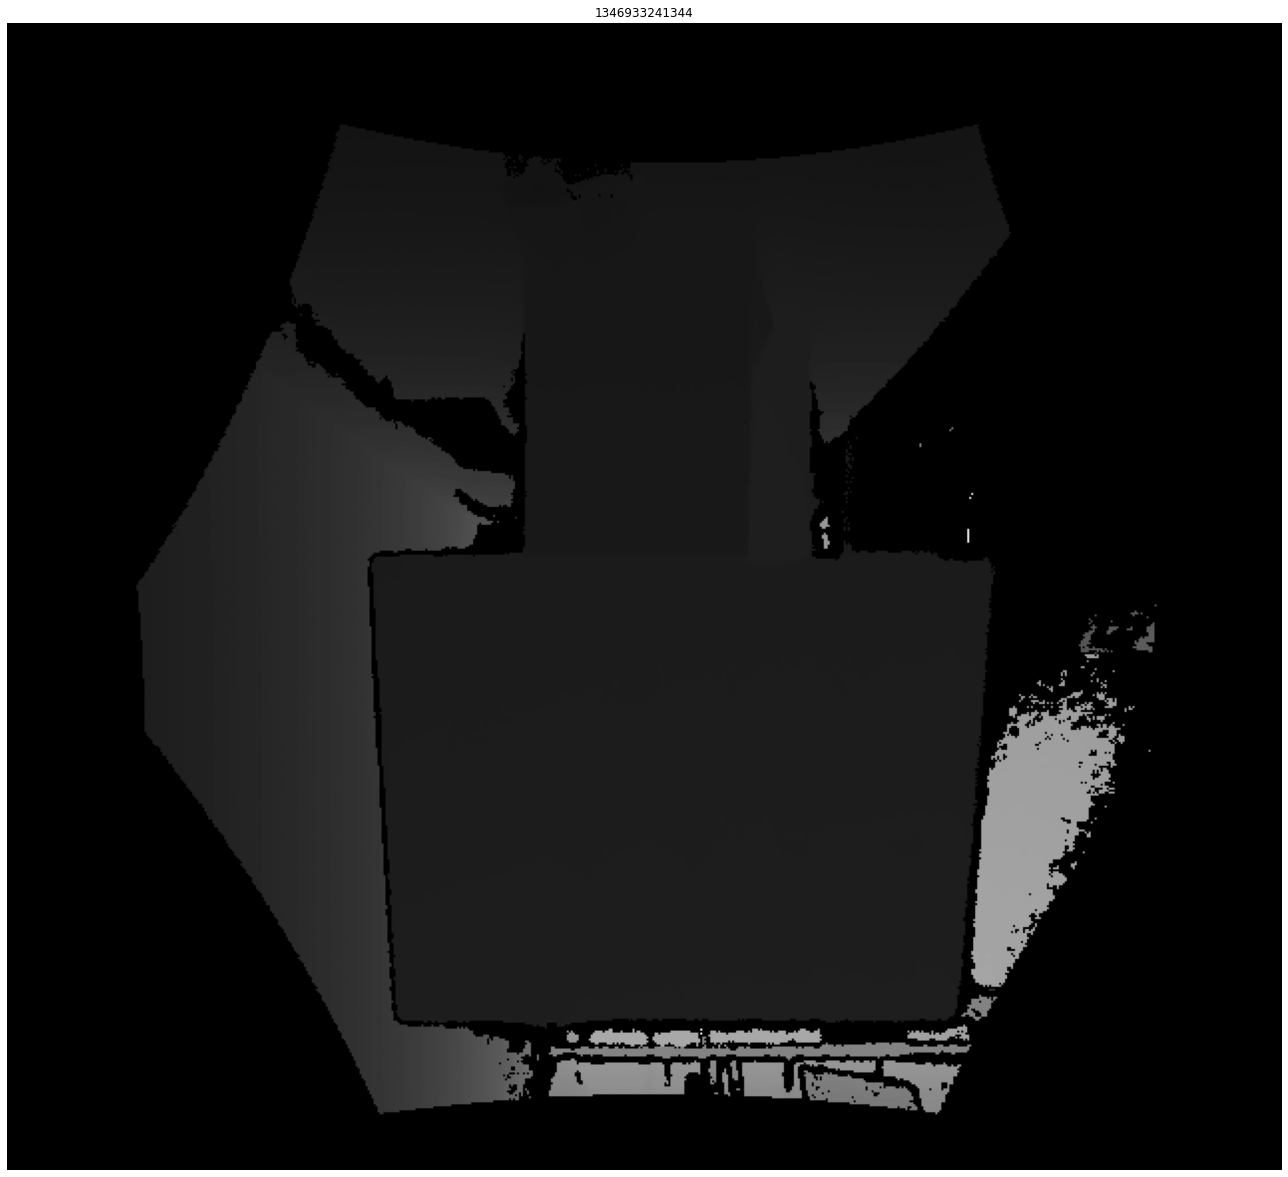

In [46]:
plot_figures({check_azure_key: azure_depths[check_azure_key + depth_ext]})

In [47]:
# Add transformation to the list
T_out.append(T_final)

In [48]:
# Optional. Save if needed
# np.save('calib_output/azure2s10_standard_extrinsics1', T_final)

In [49]:
# Merge all the transformations together
T_avg = average_transforms(T_out)

In [50]:
T_avg

array([[-0.99997931, -0.0056163 ,  0.00313742,  0.00269367],
       [ 0.00530618, -0.9958031 , -0.09136757,  0.10471359],
       [ 0.0036374 , -0.09134903,  0.99581229,  0.05516527],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [96]:
np.save('calib_output/azure2s10_standard_extrinsics', T_avg)